# Hispatholgic Cancer Detection

## Identify metastatic tissue in histopathologic scans of lymph node sections

## Background

This is a Kaggle competition, in which one must create an algorithm that identifies metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a modified version of the PatchCamelyon [(PCam)](https://github.com/basveeling/pcam) benchmark dataset.

PCam is highly interesting for both its size, simplicity to get started on, and approachability. In the authors' words:

    [PCam] packs the clinically-relevant task of metastasis detection into a straight-forward binary image classification task, akin to CIFAR-10 and MNIST. Models can easily be trained on a single GPU in a couple hours, and achieve competitive scores in the Camelyon16 tasks of tumor detection and whole-slide image diagnosis. Furthermore, the balance between task-difficulty and tractability makes it a prime suspect for fundamental machine learning research on topics as active learning, model uncertainty, and explainability. 

### Domain Knowledge

More information on metastases detection here: [Improving the Detection of Cancer Metastasis in Lymph Nodes](https://camelyon16.grand-challenge.org/Background/).



## Dataset

The [dataset](https://www.kaggle.com/c/histopathologic-cancer-detection/data) consists of 220,025 image patches of size 96x96 in the training set. 130,908 images are classified as negative and 89,117 are classified as positive.  The test set consists of 55,000 images. Each image file is named with an image id. The file train_labels.csv provides the ground truth information for the training images.

The goal is to correctly predict the label (positive or negative) for the images in the test set. A positive label indicates that the center 32x32 region of a patch contains at least one pixel of tumor tissue. If there is a tumor on the tissue that is outside this 32x32 center region, then it is not considered for labeling purposes. The outer region is provided to ensure consistent behavior in [fully-convolutional models](http://deeplearning.net/tutorial/fcn_2D_segm.html) that do not use zero-padding, when padding is applied to a whole-slide image.

## Evaluation Metric

The competition evaluation metric will be based on the area under the [ROC curve](http://gim.unmc.edu/dxtests/roc3.htm) between the predicted label and the actual label. From Wikipedia, "the ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied". 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

## Importing the Data

In [2]:
path = Path('Data/HCD')

The lines of code below were use to download the training and testing files from Kaggle and then extracting into a folder named Data/HCD.

In [3]:
#! sudo pip install kaggle --upgrade

In [4]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

In [4]:
#! kaggle competitions download -c histopathologic-cancer-detection -f test.zip -p {path/'Test'}

In [5]:
# import zipfile
# zipref = zipfile.ZipFile(path/'Test/test.zip', 'r')
# zipref.extractall(path/'Test')
# zipref.close()

In [3]:
# listing the folder directory
path.ls()

[PosixPath('Data/HCD/Train'),
 PosixPath('Data/HCD/sample_submission.csv'),
 PosixPath('Data/HCD/models'),
 PosixPath('Data/HCD/Test'),
 PosixPath('Data/HCD/.ipynb_checkpoints'),
 PosixPath('Data/HCD/train_labels.csv')]

In [ ]:
# listing the first 5 files in the train folder
fnames = get_image_files(path/'Train')
fnames[:5]

We can use pandas to create a dataframe for the labels

In [4]:
dftrain=pd.read_csv(path/'train_labels.csv')
dftrain.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Notice the labels are listed as 1 for positive or 0 for negative

In [ ]:
# Now to get a description on this dataframe of labels
dftrain.describe()

## Visualizing the Data

We'll look at one image by using one of the filenames above and the fastai command open_image. We also use the fastai class ImageBBox to create a boundary box on the image that defines that 32x32 region where the tumor is classified.

In [ ]:
img = open_image(path/'Train/.tif') # returns an image object created from an image inside a filename
boundarybox = ImageBBox.create(*img.size, [[32, 32, 64, 64]]) 
# creates an image with a boundary box drawn from coordinates within the image
img.show(y=boundarybox, title="Sample Tissue with Boundary Box") 
img.size

In [ ]:
# Looking at more sample images
sample_images = random.sample(fnames, 64) # choosing 64 unique random images from the training set

imgs = []
for image in sample_images:
    file_path = os.path.join(path/'Train', image.parts[-1])
    im = open_image(file_path)
    imgs.append(im)

show_all(imgs, 8, (8,8)) # Fastai command to show images by rows and figure size

### Now we'll plot the images and label them as positive or negative

In [6]:
# from pil import PIL

In [4]:
shuffled_images = shuffle(dftrain)
fig, ax = plt.subplots(2, 5, figsize=(20,8))
fig.title('Histopathologic Scans of Lymph Node Sections')

# Positive-labeled images
# Looping over 5 images from a shuffled set in the training set with labels = 1 (positive)
for i, idx in enumerate(shuffled_images[shuffled_images['label'] == 1]['id'][:5]):
    file_path = os.path.join(path/'Train', idx)
    ax[1,i]imshow(readImage(file_path + '.tif'))
    
    # Creating rectangular patches. Patches is a Matplotlib function
    bbox = patches.Rectangle((32,32), 32,32, linewidth=4, edgecolor='b',
                             facecolor='none', linestyle=':', capstyle='round')
    # adding the bounding box to the images
    ax[1,i].add_patch(bbox) 

ax[1,0].set_ylabel('Positive Tissue Samples', size='large')

# Negative-labeled images
# Looping over 5 images from a shuffled set in the training set with labels = 0 (negative)
for i, idx in enumerate(shuffled_images[shuffled_images['label'] == 0]['id'][:5]):
    file_path = os.path.join(path/'Train', idx)
    ax[0,i].imshow(readImage(file_path + '.tif'))
    
    bbox = patches.Rectangle((32,32), 32,32, linewidth=4, edgecolor,='b',
                            facecolor='none', linestyle=':', capstyle='round')
    
    ax[0,i].add_patch(bbox)
    
ax[0,0].set_ylabel('Negative Tissue Samples', size='large')    

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Creating a Databunch

A databunch is used to prepare the data so it can be trained using the fastai [Learner class](https://docs.fast.ai/basic_train.html#Learner).

### Data Augmentation

Data augmentation is technique used to increase the amount of training data by using information only in our training dataset. It can be used as a way we to reduce overfitting on models.

We will flip the images horizontally, vertically, add a little bit of brightness, zoom and lighting. For more information on doing data augmentation with the fastai library, refer to [this link](https://docs.fast.ai/vision.transform.html#Data-augmentation).

In [5]:
tfms=get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1,
               max_lighting=0.2, max_warp=0., p_affine=0.75, p_lighting=0.75)

### Defining The Validation Set

We will set the validation set to be 5% of the training set

In [6]:
# validation is 5% of the train set
valid_size = int(.05 *len(dftrain)) 
valid_size

11001

In [7]:
valid_idx = range((len(dftrain) - valid_size), len(dftrain))
valid_idx

range(209024, 220025)

### The Databunch

In [8]:
data = (ImageItemList.from_csv(path, 'train_labels.csv', folder='Train', suffix='.tif')
        .split_by_idx(valid_idx)  # validation set
        .label_from_df(columns='label') # the data is labeled from the train_labels.csv file
        .add_test_folder('Test') # specify the directroy where the test set images are located
        .transform(tfms, size=224) # data augmentation and image size of the transformations
        .databunch()
        .normalize(imagenet_stats)) # normalizing the data using the mean and the standard deviation

Now that the databunch is created, there are many functions that can be called from the object "data".

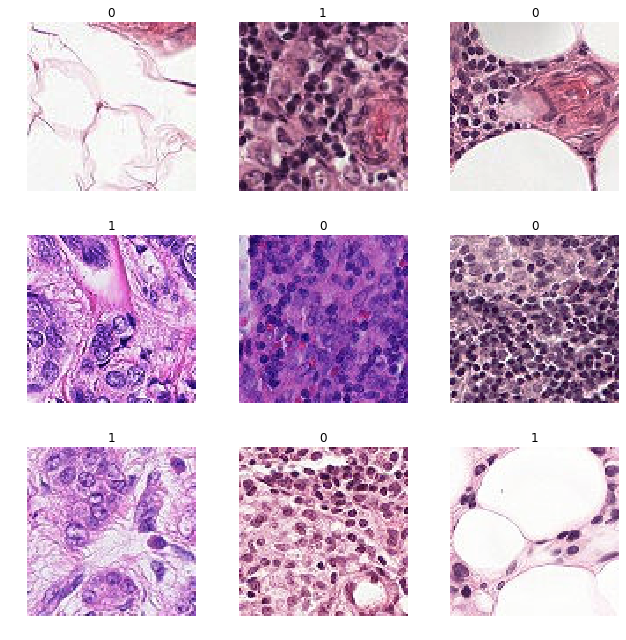

In [14]:
data.show_batch(rows=3, figsize=(6,6)) # shows a random batch of images with their labels from the dataset

In [21]:
data.classes # shows what the classes are

[0, 1]

In [15]:
data.batch_size # shows the batch size. By default this number is 64

64

In [ ]:
data.train something and valid somethings and test someting sizes

In [ ]:

len(data.train_ds), len(data.vaild_ds) len(data.test_ds)

## Training The Model

### Model architecture

To train this model we will use a technique called Transfer Learning with ResNet50 architecture that was trained on ImageNet.

In [9]:
arch = models.resnet50

### Metrics

In [10]:
from sklearn.metrics import roc_auc_score
# the sklearn library has a function that calculate the area under the ROC curve

In [11]:
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1]))

In [12]:
metrics = [accuracy, auc_score]

### Training the model

In [13]:
wd=0.1 # weight decay

In [14]:
learn = create_cnn(data, arch=arch, metrics=metrics, wd=wd)

In [16]:
learn.lr_find() 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


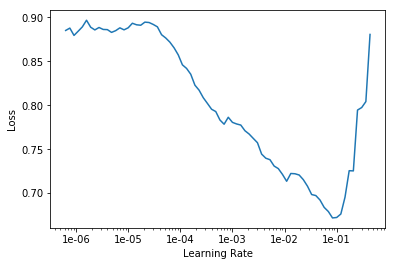

In [17]:
learn.recorder.plot() # We plot the learning rate

In [18]:
lr=1e-2

In [19]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,auc_score
1,0.187057,0.162236,0.939460,0.981548
2,0.166540,0.151583,0.946187,0.985252
3,0.134408,0.130432,0.955459,0.988021
4,0.122576,0.101048,0.966458,0.991777
5,0.112336,0.090799,0.968367,0.993268


In [20]:
learn.save('hcd-stage-1') # We save the model up to this point

### Fine Tuning

The model has achieved an accuracy of 96.8%, but this can be improved.  Previously, by default, the model was trained with its initial layers frozen.

In [21]:
learn.load('hcd-stage-1');

In [22]:
learn.unfreeze()

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


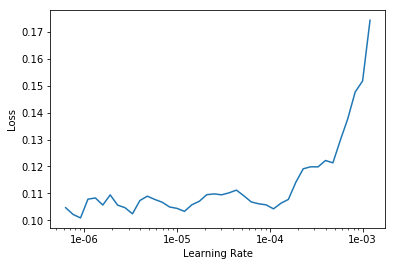

In [24]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(3, slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,auc_score
1,0.124227,0.100186,0.966276,0.992083
2,0.095739,0.080548,0.973821,0.994709
3,0.085832,0.070443,0.977457,0.995634


In [26]:
learn.save('hcd-stage-2')

In [31]:
learn.load('hcd-stage-2');

In [32]:
learn.unfreeze()

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


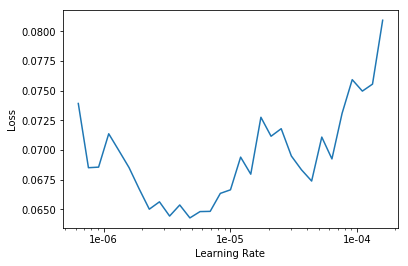

In [34]:
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(2, slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,auc_score
1,0.079009,0.070512,0.977820,0.995829
2,0.088317,0.067479,0.978275,0.995923


In [36]:
learn.save('hcd-stage-3')

In [37]:
learn.load('hcd-stage-3');

In [38]:
learn.unfreeze()

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


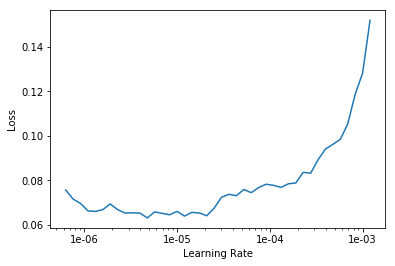

In [40]:
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(2, slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,auc_score
1,0.070462,0.065753,0.979275,0.996239
2,0.070375,0.065627,0.978366,0.996262


In [42]:
learn.save('hcd-stage-4')

In [ ]:
learn.load('hcd-stage-4');

In [37]:
#inter = ClassificationInterpretation.from_learner(learn)

In [38]:
#inter.plot_top_losses(9, figsize=(10,10))

In [39]:
#inter.plot_confusion_matrix()

In [43]:
preds, test_labels = learn.TTA(ds_type=DatasetType.Test)
#preds, labels = learn.get_preds(ds_type=DatasetType.Test)

In [44]:
len(preds)

57458

In [45]:
testdf = data.test_ds.to_df()
testdf.columns = ['id','label']
testdf['label'] = preds[:,1]
testdf['id'] = testdf['id'].apply(lambda fp: Path(fp).stem)
testdf.head()

,id,label
0,c0b24bad7fdeca3d8735e7850e024bf875787f83,0.999621
1,269d2cfba4e896769ab014b2ff1febed375d0d4b,0.052729
2,4c28a41001aac38890ca3231c83287cb5dafc315,0.030653
3,7f8ee7d399bf9136e8ef5feba087c2072486ca4b,0.960966
4,f12574827d49289645eb1d89c3a2afd12c516bca,0.000035


In [46]:
testdf.to_csv('submission37 - Resnet50 - paffine=0.1 - maxwarp=0, size=224.csv', index=False)